In [3]:
!pip install xlsxwriter


You should consider upgrading via the 'c:\python39\python.exe -m pip install --upgrade pip' command.


In [4]:
%pip install xlrd

Note: you may need to restart the kernel to use updated packages.


'D:\Program' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
%pip install matplotlib
%pip install pandas
%pip install xlsxwriter


Note: you may need to restart the kernel to use updated packages.


'D:\Program' is not recognized as an internal or external command,
operable program or batch file.


Note: you may need to restart the kernel to use updated packages.


'D:\Program' is not recognized as an internal or external command,
operable program or batch file.


Note: you may need to restart the kernel to use updated packages.


'D:\Program' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
from functools import reduce
from random import random
from random import choice
import pandas as pd
import math
# !pip install matplotlib
import matplotlib.pyplot as plt
import xlsxwriter
import io
import timeit

In [7]:
def find_path(graph, start, end, path=None):
    if not path:
        path = []
    path = path + [start]
    if start == end:
        return path
    for node in graph[start - 1]:
        if node not in path:
            new_path = find_path(graph, node, end, path)
            if new_path:
                return new_path
    return None

In [8]:
def find_candidates(graph, operations_left, current_time, cycle_time, times_list):
    schedulable_operations = []

    # Find schedulable operations
    for operation_j in operations_left:  # iterate through
        is_operation_candidate = True
        for operation_i in [operation for operation in operations_left if operation != operation_j]:
            if find_path(graph, operation_i, operation_j) is not None:
                is_operation_candidate = False
        if is_operation_candidate:
            schedulable_operations.append(operation_j)

    # Find candidate operations
    candidate_operations = []
    for operation in schedulable_operations:
        if times_list[operation - 1] <= (cycle_time - current_time):
            candidate_operations.append(operation)
    return candidate_operations

In [9]:
# find operations that can be moved to left station
def operations_to_left(operations_left, operations_right, times_list, graph, cycle_time):
    movable_operations = []
    left_station_time = reduce(lambda prev_sum, op: prev_sum + times_list[op - 1], operations_left, 0)

    for operation in operations_right:
        if left_station_time + times_list[operation - 1] > cycle_time:
            continue
        can_move = True

        # Check if candidate operation has no predecessors in right station
        for operation_predecessor in [op_pre for op_pre in operations_right if op_pre != operation]:
            if find_path(graph, operation_predecessor, operation):
                can_move = False
        if can_move:
            movable_operations.append(operation)
    return movable_operations

In [10]:
# find operations that can be moved to right station
def operations_to_right(operations_left, operations_right, times_list, graph, cycle_time):
    movable_operations = []
    right_station_time = reduce(lambda prev_sum, op: prev_sum + times_list[op - 1], operations_right, 0)

    for operation in operations_left:
        if right_station_time + times_list[operation - 1] > cycle_time:
            continue
        can_move = True

        # Check if candidate operation has no successors in left station
        for operation_successor in [op_suc for op_suc in operations_left if op_suc != operation]:
            if find_path(graph, operation, operation_successor):
                can_move = False
        if can_move:
            movable_operations.append(operation)
    return movable_operations

In [11]:
def heuristic_procedure(operations_num, adjacency_matrix, cycle_time, times_list, priority_list):
    operations_left = [op for op in range(1, operations_num + 1)]
    operations_processed = []
    stations_operations = [[]]
#     station_time = dict()
    stations_num = 1
    current_time = 0

    while operations_left:
        candidate_operations = find_candidates(adjacency_matrix, operations_left, current_time, cycle_time, times_list)
        # if candidate operations list is empty then add new station
        if not candidate_operations:
            stations_num += 1
            stations_operations.append([])
            
            current_time = 0
            continue

        # sort by execution time [priority] in descending order
        candidate_operations = sorted(candidate_operations, key=lambda operation: priority_list[operation - 1])
        # selected_operation = candidate_operations[0]
        selected_operation = candidate_operations[-1]
        
        operations_left.remove(selected_operation)
        operations_processed.append(selected_operation)
        current_time += round(times_list[selected_operation - 1],2)
        stations_operations[-1].append(selected_operation)
#         station_time[stations_num] = round(current_time,2)
    return stations_num, stations_operations #, station_time

In [12]:
def local_search_procedure(stations_num, stations_operations, times_list, adjacency_matrix, cycle_time):
    for station in range(1, stations_num):
        while True:
            dirty_flag = False  # flag that indicates that any changes were made
            left_movable_operations = operations_to_left(stations_operations[station - 1], stations_operations[station],
                                                         times_list, adjacency_matrix, cycle_time)
            left_movable_operations = sorted(left_movable_operations, key=lambda op: times_list[op - 1])

            # move operations to left station while left station time does not exceed cycle time
            left_station_time = reduce(lambda prev_sum, op: prev_sum + times_list[op - 1],
                                       stations_operations[station - 1], 0)
            right_station_time = reduce(lambda prev_sum, op: prev_sum + times_list[op - 1],
                                        stations_operations[station], 0)
            for operation in left_movable_operations:
                if left_station_time + times_list[operation - 1] <= cycle_time:
                    stations_operations[station - 1].append(operation)
                    stations_operations[station].remove(operation)
                    left_station_time += times_list[operation - 1]
                    dirty_flag = True
                else:
                    break
            left_movable_operations = operations_to_left(stations_operations[station - 1], stations_operations[station],
                                                         times_list, adjacency_matrix, cycle_time)
            right_movable_operations = operations_to_right(stations_operations[station - 1],
                                                           stations_operations[station], times_list, adjacency_matrix,
                                                           cycle_time)
            exchangeable_operations = [[left_op, right_op] for left_op in left_movable_operations for right_op in
                                       right_movable_operations]
            exchangeable_operations = filter(
                lambda op_pair: (times_list[op_pair[1] - 1] - times_list[op_pair[0] - 1]) > 0, exchangeable_operations)
            exchangeable_operations = sorted(exchangeable_operations,
                                             key=lambda op_pair: times_list[op_pair[1] - 1] - times_list[
                                                 op_pair[0] - 1])
            for operations_pair in exchangeable_operations:
                if left_station_time - times_list[operations_pair[0] - 1] + times_list[
                            operations_pair[1] - 1] <= cycle_time:
                    # move operations_pair[1] to left station
                    stations_operations[station - 1].append(operations_pair[1])
                    stations_operations[station].remove(operations_pair[1])
                    # move operations_pair[0] to right station
                    stations_operations[station].append(operations_pair[0])
                    stations_operations[station - 1].remove(operations_pair[0])
                    # recalculate left and right stations times
                    left_station_time += (times_list[operations_pair[1] - 1] - times_list[operations_pair[0] - 1])
                    right_station_time += (times_list[operations_pair[0] - 1] - times_list[operations_pair[1] - 1])
                    dirty_flag = True
                else:
                    break

            if not dirty_flag:
                break

    # try to reduce number of work stations
    while not stations_operations[-1]:
        del stations_operations[-1]
        stations_num -= 1
    return stations_num, stations_operations

In [13]:
def genetic_algorithm_procedure(population_num, generations_num, operations_num, adjacency_matrix, cycle_time,
                                times_list, priority_list, stations_num, stations_operations, elitist_part,
                                coin_probability, mutation_probability):
    population = []
    fitness_func_values = {}

    # create first generation
    for i in range(1, population_num):
        population.append([random() for _ in range(operations_num)])
        # calculate fitness function values for each chromosome in population
        for chromosome in population:
            # Heuristic priority-based procedure
            (chromosome_stations_num, chromosome_stations_ops) = heuristic_procedure(operations_num, adjacency_matrix,
                                                                                     cycle_time, times_list,
                                                                                     priority_list)
            # The local search procedure
            (chromosome_stations_num, chromosome_stations_ops) = local_search_procedure(stations_num,
                                                                                        chromosome_stations_ops,
                                                                                        times_list, adjacency_matrix,
                                                                                        cycle_time)
            fitness_func_values[''.join([('%.5f' % x) for x in chromosome])] = {'stations_num': chromosome_stations_num,
                                                                                'stations_ops': chromosome_stations_ops}

    # iterations for each generation
    for generation_no in range(generations_num):
        # reproduction stage
        new_population = list(population[0: int(elitist_part * len(population))])
        # crossovers stage
        for i in range(int(population_num * (1 - elitist_part - mutation_probability))):
            parent1, parent2 = choice(population), choice(population)
            new_gene = []
            for gene1, gene2 in zip(parent1, parent2):
                if random() < coin_probability:
                    new_gene.append(gene1)
                else:
                    new_gene.append(gene2)
            new_population.append(new_gene)
        # mutation stage
        for i in range(int(population_num * mutation_probability)):
            new_population.append([random() for _ in range(operations_num)])
        population = new_population

        # calculate fitness function values for each chromosome in population
        for chromosome in population:
            # Heuristic priority-based procedure
            (chromosome_stations_num, chromosome_stations_ops) = heuristic_procedure(operations_num, adjacency_matrix,
                                                                                     cycle_time, times_list,
                                                                                     priority_list)
            # The local search procedure
            (chromosome_stations_num, chromosome_stations_ops) = local_search_procedure(stations_num,
                                                                                        chromosome_stations_ops,
                                                                                        times_list, adjacency_matrix,
                                                                                        cycle_time)
            fitness_func_values[''.join([('%.5f' % x) for x in chromosome])] = {'stations_num': chromosome_stations_num,
                                                                                'stations_ops': chromosome_stations_ops}
        # sort population by fitness function values
        population.sort(
            key=lambda chromosome: fitness_func_values[''.join([('%.5f' % x) for x in chromosome])]['stations_num'])

    # get the best individual from the last population and compare its value with the found value
    best_value = fitness_func_values[''.join([('%.5f' % x) for x in population[0]])]
    if best_value['stations_num'] < stations_num:
        stations_num = best_value['stations_num']
        stations_operations = best_value['stations_ops']
    return stations_num, stations_operations

    Task  Model 1  Model 2  Model 3  Model 4 Successors    Detail Name  \
0    1.0     14.0     34.0     15.0     10.0        2,4   Total Models   
1    2.0     12.0     15.0     11.0     17.0          3    Total Tasks   
2    3.0     39.0     47.0     40.0     51.0        5,8     Demand (1)   
3    4.0      3.0      4.0      4.0      7.0          6     Demand (2)   
4    5.0     11.0     13.0     10.0      9.0        7,9     Demand (3)   
5    6.0     19.0     29.0     21.0     21.0          8     Demand (4)   
6    7.0     11.0     14.0      9.0     10.0         10     Work weeks   
7    8.0     21.0     38.0     28.0     32.0          9    Work shifts   
8    9.0     13.0     19.0     15.0     17.0         10     Shift time   
9   10.0     33.0     41.0     42.0     43.0          0     Efficiency   
10   0.0      0.0      0.0      0.0      0.0          0  Repositioning   

    Details  
0      4.00  
1     10.00  
2   1000.00  
3   1000.00  
4   1000.00  
5   1000.00  
6     50.00  

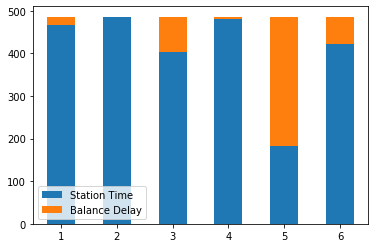

In [20]:
def solve(xlsfile):
    # Read input file
    # Input file structure:
    # 1. Cycle time
    # 2. Operations number
    # 3. List of execution times for each operation
    # 4. Matrix of dependencies of operations
    # 5. Population size for genetic algorithm
    # 6. Number of generations
    # 7. Part of population that will be mutated
    # 8. Part of population that will be copied to next generation in elitist strategy
    # 9. Coin probability used to choose specific gene from one of parent chromosomes
#     num_models = int(input("Enter the number of models: "))
#     num_tasks = int(input("Enter the number of tasks: "))
    start = timeit.default_timer()

    #Your statements here

    
    
    n = input("Enter sheet number: ")
#     n = '8'
    
    test = "test" + n
    excel_file = 'test.xlsx'
#     D:\Code\BTP\main BTP\testcases
    df = pd.read_excel(r'D:\Code\BTP\main BTP\testcases\copytest.xls', sheet_name = test)
    df = df.fillna(0)
    print(df)
#     excel_file.close()
    details = df['Details'].tolist()
    idx = 0
    num_models = int(details[idx])
    idx += 1
    num_tasks = int(details[idx])
#     num_tasks = 9   ###
    idx += 1
    
    all_tasks = [int(x) for x in df["Task"].to_list()]
#     print("all_tasks",all_tasks)
    
    durations = []
    
    for i in range(num_models):
        model_name = "Model" + " " + str(i+1)
        durations.append(df[model_name].to_list())
#     print("durations",durations) 
    
    
    pred = df["Successors"].tolist()
    
    print(pred)
    g = []
        
    for i in range(num_tasks):
        z = pred[i]
#         print(z,type(z))
        if type(z) == int:
            g.append([z])
        
        elif type(z) == float:
            z = int(z)
            g.append([z])
        
        else:
            g.append(list(map(int,z.split(','))))
    
#         print(g)
    
#     priority_list = [(int(x)) for x in times_list]
#     priority_list = [x / max(priority_list) for x in priority_list]
    
    
    
#     annual demand
    
#     detail_name = df['Detail Name'].tolist()
    
#     print(detail_name)
    
    
#     print(details)
#     [10000.0, 50.0, 5.0, 7.5, 0.96, 1.6600000000000001, nan, nan, nan, nan]
#     d1 = round(details[2],2)
#     d2 = round(details[3],2)
    demand = []
    for i in range(num_models):
        demand.append(details[idx])
        idx += 1
    
#     print("demands", demand)
    no_weeks = round(details[idx],2)
    idx += 1
    no_shifts = round(details[idx],2)
    idx += 1
    no_hours = round(details[idx],2)
    idx += 1
    E = round(details[idx],2)
    idx += 1
    repo_time = round(details[idx],2)
    
#     D1 = round(details[6],2)
#     D2 = round(details[7],2)
#     d = [D1,D2]
    rp = dict()
    for i in range(num_models):
#         s = "rp" + str(i+1)
#         d = 'D'+str(i+1)
        rp[i+1] = round(demand[i] /(no_weeks * no_shifts * no_hours),2)
    rp[1] = 4
    rp[2] = 6
    print("rp",rp)
#     rp[1] = 4
#     rp[2] = 6
    if num_models == 1:
        times_list = [round(durations[0][i],2) for i in range(len(durations[0]))]
    else:
        times_list = []
        sep_times = []
        for i in range(num_tasks):
            t = 0
            for j in range(num_models):
                t += rp[j+1] * durations[j][i] 

                
                
                
            times_list.append(round(t,2))
            
    print("durations: ",durations)    
#     times_list = total_times = [rp1 * durations[0][i] + rp2 * durations[1][i] for i in range(num_tasks)]
#     print("tl",times_list)
    print("times_list = ",times_list)
    tl_dict = dict()
    
    for i in range(len(times_list)):
        tl_dict[i+1] = times_list[i]


    ct = round((60*E)/(sum(rp.values())),2)
#     print(round(60*E,2))
#     print("ct",ct)
    service_time = round(ct - repo_time,2)
#     print("serv", service_time)
    
    repo_eff = service_time/ct
        
    AT = math.floor(60*E*repo_eff)    
#     print(len(times_list))
#     print("AT",AT)
    
    print("service time: ", service_time)
    print("repo_eff: ", repo_eff)
    print('AT: ', AT)
    
#     with open('D:\Code\BTP\gen\in_two.txt') as f:
#     cycle_time = int(f.readline())
    if num_models == 1:
        cycle_time = service_time
    else:  
        cycle_time = AT
    print("CT: ", cycle_time)
    print('Max Operation Time:', max(times_list))

    if cycle_time < max(times_list):
        print('Decrease the demand!!!')
        cycle_time = max(times_list)
    print("final_CT = ", cycle_time )
#     cycle_time = service_time
#     print(cycle_time)
    print('Average task time:', sum(times_list)/len(times_list))
    print("w* = ", int(sum(times_list)/max(times_list)))
    operations_num = num_tasks
    population_num = num_tasks
    generations_num = 2
    mutation_probability = 0.2
    elitist_part = 0.2
    coin_probability = 0.6
#     operations_num = int(f.readline())
#     times_list = [(int(x)) for x in f.readline().split()]
#     priority_list = [(int(x)) for x in times_list]
#     priority_list = [(int(x)) for x in times_list]
#     priority_list = [x / max(priority_list) for x in priority_list]
    priority_list = [int(x / max(times_list)) for x in times_list]
#     adjacency_matrix = [[(int(x)) for x in f.readline().split()] for _ in range(operations_num)]
    adjacency_matrix = g
#     print("g",adjacency_matrix)
#     print(len(priority_list))
    # genetic algorithm parameters
#     population_num = int(f.readline())
#     generations_num = int(f.readline())
#     mutation_probability = float(f.readline())
#     elitist_part = float(f.readline())
#     coin_probability = float(f.readline())

    # Heuristic priority-based procedure
    (stations_num, stations_operations) = heuristic_procedure(operations_num, adjacency_matrix, cycle_time, times_list,
                                                              priority_list)
    
    

    # The local search procedure
    (stations_num, stations_operations) = local_search_procedure(stations_num, stations_operations, times_list,
                                                                 adjacency_matrix, cycle_time)

#     # Genetic algorithm and chromosome representation
    (stations_num, stations_operations) = genetic_algorithm_procedure(population_num, generations_num, operations_num,
                                                                      adjacency_matrix, cycle_time, times_list,
                                                                      priority_list, stations_num, stations_operations,
                                                                      elitist_part, coin_probability,
                                                                      mutation_probability)

#     Write results
#     Output file structure:
#     1. Final minimal number of stations
#     2. Number of operations
#     3. Lists of operations per each station
#     with open(r"D:\Code\BTP\gen\testcases\output.txt", "w") as f:
#         f.write(str(stations_num) + '\n')
#         f.write(str(operations_num) + '\n')
        
#         for station_operations in stations_operations:
#             f.write(' '.join([str(x) for x in station_operations])  + '\n')
#     print(station_time)
#     print('Station number is %d' % stations_num)
#     print("Cycle Time is: ", cycle_time)
#     print("Workstations are: ")
#     i = 0
#     print("StNum  Tasks St Time")
#     print(stations_operations)
#     for station_operations in stations_operations:
#             print(str(i+1) + "   " + ' '.join([str(x) for x in station_operations])  + "   " + str(station_time[i+1]) + '\n')
#             i+=1
#     print(station_time)
    station_time = dict()
    
    for i in range(len(stations_operations)):
        curr = stations_operations[i]
        time = 0
        for j in range(len(curr)):
            time += tl_dict[curr[j]]
            
        station_time[i+1] = time
        
    s_time = [station_time[i+1] for i in range(len(station_time))]
    stations = [i+1 for i in range(len(station_time))]
    stNum = pd.Series(stations)
    tsk = pd.Series(stations_operations)
#     tsk = pd.Series(' '.join([str(x) for x in stations_operations]))
    stTime = pd.Series(s_time)
    bal_del = [cycle_time - station_time[i+1] for i in range(len(station_time))]
    bd = pd.Series(bal_del)
#     eff = [0]*(num_tasks)
#     Eb = pd.Series([])
    efficiency = sum(s_time)/(len(stations) * cycle_time)

    
    outDF = pd.DataFrame({"Station Number" : stNum , "Tasks" : tsk, "Station Time" : stTime, "Balance Delay" :  bd})
                         # })
#     print(outDF)1
    savefile = "sol" + test
    outDF.to_excel(r'D:\Code\BTP\main BTP\testcases\sol1.xlsx', sheet_name = savefile, index = False)
    
    
    #Output using excel writer
#     save = "Solution" + n
#     sheet_name = save
#     writer = pd.ExcelWriter(r'D:\Code\BTP\gen\testcases\sol.xlsx', engine='xlsxwriter')
#     df.to_excel(writer, sheet_name=sheet_name)
#     colors = ['#377EB8', '#FF7F00']
#     workbook  = writer.book
#     worksheet = writer.sheets[sheet_name]
#     chart = workbook.add_chart({'type': 'column'})
#     chart.add_series({
#         'name':       stations,
#         'categories': ['Sheet1', 1, 0, 4, 0],
#         'values':     ['Sheet1', 1, col_num, 4, col_num],
#         'fill':       {'color':  colors[col_num - 1]},
#         'overlap':    -10,
#     })
    
#     fig_dict = dict()
    stIdx = [str(x) for x in stations]
#     fig_dict['Station'] = stIdx

#     for i in range(len(durations)):
#         k = "Model" + " " + str(i+1)
        
#         fig_dict[k] = durations[i] 
#         print(durations[i][i]*10)
    
#     print('fig_dict: ',fig_dict)
#     print('stime: ', s_time)
#     print('baldel: ', bal_del)
    
#     idx_chart = stations
#     chart = pd.DataFrame({"Station Time" : s_time, "Balance Delay" :  bal_del}, index = idx_chart)
#     chart = pd.DataFrame({fig_dict}, index = idx_chart)
#     print(chart)
#     ax = chart.plot.bar(rot=0,stacked=True)
    '''
#     worksheet.insert_chart('H2',ax)
    # A python dictionary

#     data = {"Car Price":[24050, 34850, 38150],

#             "Kerb Weight":[3045, 3572, 3638]

#             };

#     index     = ["Variant1", "Variant2", "Variant3"];
    
    
    
    
    
    df = pd.DataFrame({ 
    'Name': ['John', 'Sammy', 'Joe'], 
    'Age': [45, 38, 90], 
    'Height(in cm)': [150, 180, 160] }) 
    '''
    # plotting graph 
#     df.plot(x="Name", y=["Age", "Height(in cm)"], kind="bar") 
    
    
    
    

    # Dictionary loaded into a DataFrame       

#     dataFrame = pd.DataFrame(data=[fig_dict], index=stIdx);

#     print(dataFrame)

    # Draw a vertical bar chart

#     dataFrame.plot.bar(title="Workstation Loads");

#     plot.show(block=True);
    
    
    
    
    print('pairs: ', stations_operations)
    
    
    
    
    sep = "\t"
    pairs = [sep.join(str(x)) for x in stations_operations]
    
    
    
    
    
    #output using xlswriter
    # Workbook() takes one, non-optional, argument    
    # which is the filename that we want to create. 
#     sol = "Solution" + n
    workbook = xlsxwriter.Workbook(r'D:\Code\BTP\main BTP\testcases\solve+graph1.xlsx')  

    # The workbook object is then used to add new    
    # worksheet via the add_worksheet() method.   
    worksheet = workbook.add_worksheet()  

    # Create a new Format object to formats cells  
    # in worksheets using add_format() method .  

    # here we create bold format object .  
    bold = workbook.add_format({'bold': 1})  

    # create a data list .  
#     headings = ['Number', 'Batch 1', 'Batch 2']  
    headings = ['Station Number', 'Tasks',	'Station Time', 'Balance Delay']


#     data = [  
#         [2, 3, 4, 5, 6, 7],  
#         [80, 80, 100, 60, 50, 100],  
#         [60, 50, 60, 20, 10, 20],  
#     ]  
    data = [stations, pairs, s_time, bal_del]
    print("pairs: ",pairs)
    # Write a row of data starting from 'A1'  
    # with bold format .  
    worksheet.write_row('A1', headings, bold)  

    # Write a column of data starting from  
    # 'A2', 'B2', 'C2' respectively .  
    worksheet.write_column('A2', data[0])  
    worksheet.write_column('B2', data[1])  
    worksheet.write_column('C2', data[2])  
    worksheet.write_column('D2', data[3])  
    worksheet.write('E2', "Cycle Time = ")
    worksheet.write('E3', "Balance Efficiency = ")
    worksheet.write('F2', round(cycle_time,2), bold)
    worksheet.write('F3', round(efficiency,2), bold)
    print('Efficiency: ',efficiency)
    # Create a chart object that can be added  
    # to a worksheet using add_chart() method.  

    # here we create a stacked Column chart object .  
    chart1 = workbook.add_chart({'type': 'column', 'subtype': 'stacked'})  

    # Add a data series to a chart  
    # using add_series method.  

    # Configure the first series.  
    # = Sheet1 !$A$1 is equivalent to ['Sheet1', 0, 0].  
    chart1.add_series({  
        'name':       ['Sheet1', 0, 2],  
        'categories': ['Sheet1', 1, 0, len(stations)+1, 0],  
        'values' : ['Sheet1', 1, 2, len(stations)+1, 2],  
    })  

    # Configure a second series.  
    # Note use of alternative syntax to define ranges.  
    # [sheetname, first_row, first_col, last_row, last_col].  
    chart1.add_series({  
        'name':       ['Sheet1', 0, 3],  
        'categories': ['Sheet1', 1, 0, len(stations)+1, 0],  
        'values':     ['Sheet1', 1, 3, len(stations)+1, 3],  
    })  

    # Add a chart title   
    chart1.set_title ({'name': 'Workload'})  

    # Add x-axis label  
    chart1.set_x_axis({'name': 'Workstations'})  

    # Add y-axis label  
    chart1.set_y_axis({'name': 'Station Time'})  

    # Set an Excel chart style.  
    chart1.set_style(11)  

    # add chart to the worksheet   
    # the top-left corner of a chart   
    # is anchored to cell E2 .   
    worksheet.insert_chart('H2', chart1)  

    # Finally, close the Excel file   
    # via the close() method.   
    workbook.close()  
    
    
    
    stop = timeit.default_timer()

    print('Time taken: ', round(stop - start, 2), "s")  
    print('Output file location: ', "D:\Code\BTP\main BTP\testcases\solve+graph1.xlsx")
    
    
    
    
    
# if __name__ == "__main__":
# #     solve()
#     app.run

In [21]:
# import flask

In [ ]:
from flask import Flask
app = Flask(__name__)

@app.route('/btp')
def main_btp():
#     print('Enter sheet number')
    return 'hello'

In [23]:
# app.run

<bound method Flask.run of <Flask '__main__'>>

In [ ]:
if __name__ == "__main__":
#     solve()
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [18/Mar/2021 19:57:13] "GET / HTTP/1.1" 404 -
127.0.0.1 - - [18/Mar/2021 19:57:13] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [18/Mar/2021 19:57:18] "GET /btp HTTP/1.1" 200 -
